### Installation of packages

In [1]:
pip install tensorflow

You should consider upgrading via the '/home/studio-lab-user/.conda/envs/default/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Unzip the compressed folder consists of the train and test data of 7 classes

In [ ]:
!unzip face_emotion.zip

### Importing Required Packages

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import os
from PIL import Image
import glob

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import math

## Data Preparation

### Path of the directory is assigned to `face_dir`. Each image should be of size 48 * 48 

In [2]:
image_size = 48

face_dir = "face_emotion/"

### Assigning the path of `train` and `test` subfolders to `train_dir` and `test_dir`

In [3]:
train_dir = os.path.join(face_dir, "train")
test_dir = os.path.join(face_dir, "validation")

### Number of classes in train and validation datasets

In [4]:
print(f'No of classes : {len(os.listdir(train_dir))}')
print(f'No of Classes : {len(os.listdir(test_dir))}')   

No of classes : 7
No of Classes : 7


### Count of images of each emotion in Training dataset

In [5]:
emo_list =[]
train_size = 0
expressions = glob.glob('face_emotion/train')
for expression in expressions:
    emo_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
for emotion in emo_list:
    train_size += int(len(os.listdir(emotion)))
    print(f'Image of {emotion} : {len(os.listdir(emotion))}')
print(train_size)
    

Image of face_emotion/train/angry : 3994
Image of face_emotion/train/disgust : 436
Image of face_emotion/train/fear : 4103
Image of face_emotion/train/happy : 7164
Image of face_emotion/train/neutral : 4982
Image of face_emotion/train/sad : 4938
Image of face_emotion/train/surprise : 3205
28822


### Count of images of each emotion in validation dataset


In [6]:
emo_test_list =[]
test_size = 0
expressions = glob.glob('face_emotion/validation')
for expression in expressions:
    emo_test_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
for emotion in emo_test_list:
    test_size += int(len(os.listdir(emotion)))
    print(f'Image of {emotion} : {len(os.listdir(emotion))}')
print(test_size)

Image of face_emotion/validation/angry : 960
Image of face_emotion/validation/disgust : 111
Image of face_emotion/validation/fear : 1018
Image of face_emotion/validation/happy : 1825
Image of face_emotion/validation/neutral : 1216
Image of face_emotion/validation/sad : 1139
Image of face_emotion/validation/surprise : 797
7066


### Plotting the images from the dataset Randomly

In [7]:
import random
def plot_images(source_path):
    images_list =[]
    expressions = glob.glob(source_path + '/*')
    for expression in expressions:
        images_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
    random.shuffle(images_list)
    plt.figure(figsize=(12, 12))
    for i in range(1,20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(images_list[i], target_size=(image_size, image_size))
        plt.imshow(img)
    plt.show()

### calling the plot_images function by passing `train_dir` as path

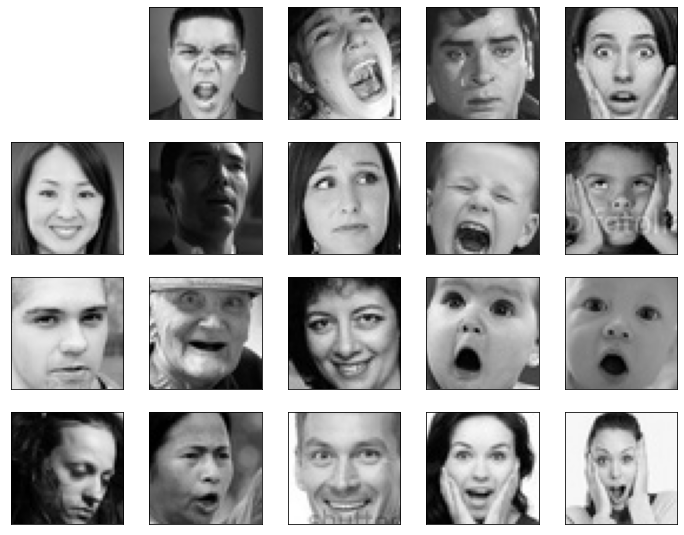

In [8]:
plot_images(train_dir)


### calling the plot_images function by passing `test_dir` as path

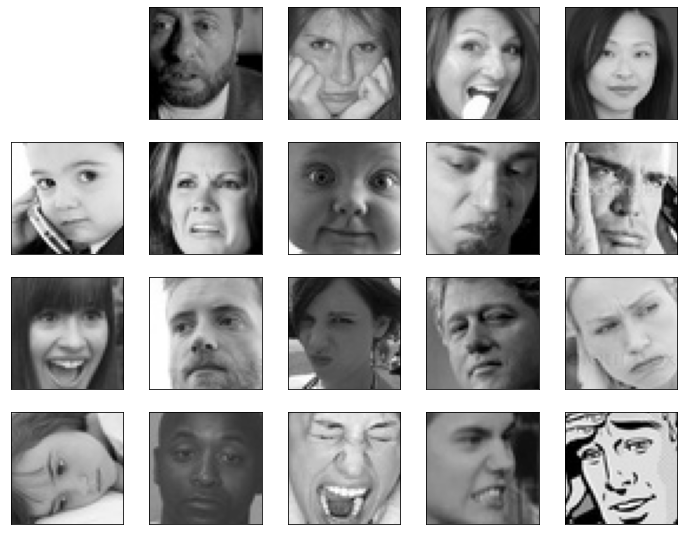

In [9]:
plot_images(test_dir)

### Function for displaying the emotion according to the expression passing as argument

In [10]:
def plot_image_acc_emotion(face_exp):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(face_dir+"/train/"+face_exp+"/"+
                      os.listdir(face_dir + "/train/" + face_exp)[i], target_size=(image_size, image_size))
        plt.imshow(img)   
    plt.show()

### PLot the images based on the emotion 'happy' which is of highest number 

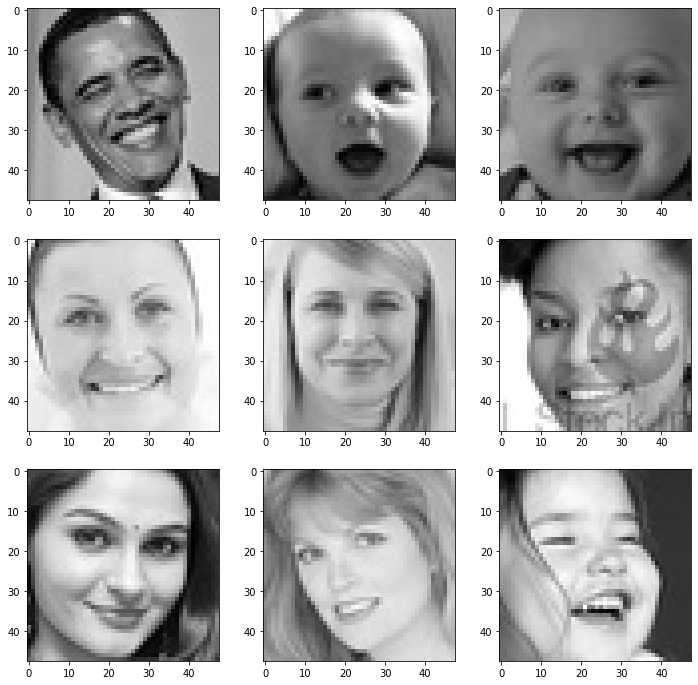

In [11]:
plot_image_acc_emotion('happy')

### PLot the images based on the emotion 'fear'

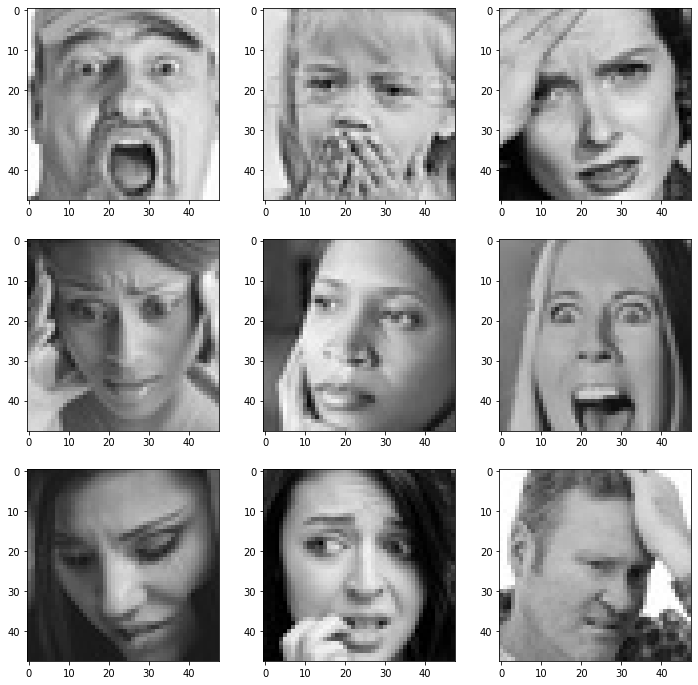

In [12]:
plot_image_acc_emotion('fear')

## Data Augmentation

### Total Images of different emotions varies, So, to balance the data, imagedatagenerator is used through which, new images will be generated according to the parameters. In training set , I split as 80:20; training:validation for testing purpose.


In [13]:
train_image_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
)

test_image_datagen = ImageDataGenerator(rescale=1./255)

### `flow_from_directory` used to read the images from the train directory path mentioned as parameter abd create two subdirectories 'training', 'validation' and stores into two different variables.

In [14]:
train_image_generator = train_image_datagen.flow_from_directory(train_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale",
        subset = 'training',                                                    
        shuffle = True)

valid_image_generator = train_image_datagen.flow_from_directory(train_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale",
        subset = 'validation' ,                                                       
        shuffle = False)


Found 23061 images belonging to 7 classes.
Found 5762 images belonging to 7 classes.


### `flow_from_directory` used to read the images from the train directory path mentioned as parameter.

In [15]:
test_image_generator = test_image_datagen.flow_from_directory(test_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale")

Found 7066 images belonging to 7 classes.


## CNN Model Building

## Create a Sequential model using Convolutional Neural Networks

In [16]:
classes = 7                # no of classes in the training set
model = Sequential([
        # Input layer
        Conv2D(64, (3,3), padding = 'same', activation='relu', input_shape=(48, 48, 1)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.2), 
             
        # CNN Layers
        Conv2D(128, (3,3), padding = 'same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Conv2D(512, (3,3), padding = 'same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Conv2D(128, (3,3), padding = 'same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),
        

        Flatten(),
        
        #Fully_Connected Layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(412, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
    
        # Output Layer
        Dense(classes, activation='softmax')
])



### Modelcheckpoint , EarlyStopping are imported from Keras library (callbacks) used to monitor the accuracy and loss during the Model Training and helps in stopping the model training when there is no change in accuracy or loss as mentioned in parameter

In [17]:
checkpoint = ModelCheckpoint("./face_emotion.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]


### Compile the model and specify loss funtion, optimizer, and learning rate

In [18]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= Adam(learning_rate = 0.01))

### Training the dataset with the model by passing `train_image_generator` and `valid_image_generator` , `epochs` and `callbacks` as parameters

In [19]:
epochs = 40
history = model.fit(train_image_generator, 
                    epochs=epochs,
                    validation_data = valid_image_generator,
                    callbacks = callbacks_list)

Epoch 1/40
181/181 [==============================] - 264s 1s/step - loss: 2.0097 - accuracy: 0.2364 - val_loss: 1.8668 - val_accuracy: 0.2485 - lr: 0.0100
Epoch 2/40
181/181 [==============================] - 264s 1s/step - loss: 1.6931 - accuracy: 0.3335 - val_loss: 1.8367 - val_accuracy: 0.2949 - lr: 0.0100
Epoch 3/40
181/181 [==============================] - 264s 1s/step - loss: 1.4603 - accuracy: 0.4295 - val_loss: 1.4811 - val_accuracy: 0.4344 - lr: 0.0100
Epoch 4/40
181/181 [==============================] - 263s 1s/step - loss: 1.3263 - accuracy: 0.4859 - val_loss: 1.3945 - val_accuracy: 0.4439 - lr: 0.0100
Epoch 5/40
181/181 [==============================] - 261s 1s/step - loss: 1.2418 - accuracy: 0.5247 - val_loss: 1.9779 - val_accuracy: 0.3292 - lr: 0.0100
Epoch 6/40
181/181 [==============================] - 261s 1s/step - loss: 1.1858 - accuracy: 0.5471 - val_loss: 1.2470 - val_accuracy: 0.5328 - lr: 0.0100
Epoch 7/40
181/181 [==============================] - 261s 1s/st

NameError: name 'model' is not defined

### `Evaluate` function is used for the evaluation of `test_image_generator` using CNN Model

In [23]:
test_loss, test_accuracy = model.evaluate(test_image_generator)
print("test_loss: %f, test_accuracy: %f" % (test_loss, test_accuracy))

56/56 [==============================] - 17s 299ms/step - loss: 1.1021 - accuracy: 0.6145
test_loss: 1.102145, test_accuracy: 0.614492


### `class_indices` is used extract dictionary of the types of emotions as key and each emotion is assigned with a number. I extracted the keys from dictionary which are emotion names and assigned to a  list `emotion_names`

In [72]:
labels = test_image_generator.class_indices
emotion_names = list(labels.keys())
print(emotion_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Passing the `test_image_generator` as argument to `predict` func and test with the model. After by using `argmax` , classes with highest probablity are produced in a array.

In [69]:
Y_pred = model.predict(test_image_generator)
y_pred = np.argmax(Y_pred, axis=1)

[6 4 3 ... 2 5 5]


### Using sklearn library , generated a confusion matrix using test set class and the Y-test

In [71]:
import sklearn
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
cf_matrix = confusion_matrix(test_image_generator.classes, y_pred)
print(cf_matrix)

Confusion Matrix
[[144   5 129 259 202 128  93]
 [ 10   1  13  31  29  14  13]
 [160  15 121 263 212 131 116]
 [249  21 226 465 412 258 194]
 [174  14 160 313 265 174 116]
 [158   9 166 283 241 163 119]
 [136   8  91 191 189  97  85]]


### Visualization of Confusion Matrix

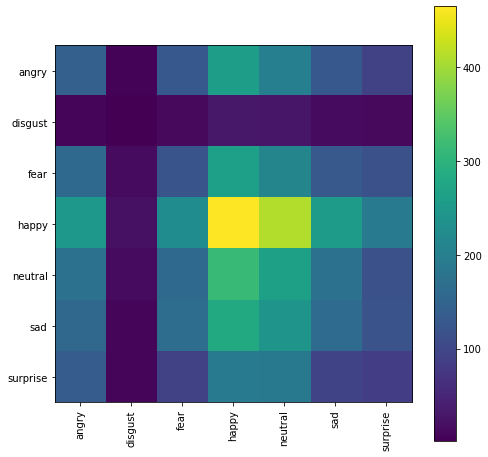

In [75]:
plt.figure(figsize=(8,8))
plt.imshow(cf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(emotion_names))
_ = plt.xticks(tick_marks, emotion_names, rotation=90)
_ = plt.yticks(tick_marks, emotion_names)